In [102]:
import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import pyfolio as pf
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import yfinance as yf

import datetime
import warnings
import pytz

from datetime import datetime

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

plt.style.use("tableau-colorblind10")
%matplotlib inline

In [103]:
# Function to fetch data for a ticker
def fetch_data(ticker, start_date, end_date):
    dft = yf.Ticker(ticker)
    df = dft.history(interval="1d", start=start_date, end=end_date)
    # df['Ticker'] = ticker
    return df

In [104]:
baro = pd.read_csv('sentiment_score.csv')

In [105]:
baro['Close'] = baro['Baro_Index']

In [106]:
baro

,BaroId,CreateDate,Baro_Index,DateTime_T4,Close
0,44D564F4-D0A8-4F68-A7D0-94A7FCEFE985,19/08/2016,42.810000,25/08/2016,42.810000
1,67A99050-2507-4C3C-8992-2E24C481AD9C,22/08/2016,9.420000,26/08/2016,9.420000
2,B859C25E-0FD9-4EC7-867A-D4DDBA4F3CFE,23/08/2016,13.720000,29/08/2016,13.720000
3,200F93C4-D4BB-4E00-8EC3-E36499C5CC9D,24/08/2016,3.030000,30/08/2016,3.030000
4,1E311B1D-1096-4BF9-BFD8-0F7032499E20,25/08/2016,4.260000,31/08/2016,4.260000
...,...,...,...,...,...
1881,6618AE52-3E77-4194-ADAD-C7AE1C616EEC,17/06/2024,58.470000,21/06/2024,58.470000
1882,26C66803-9BFF-4CD6-B6B7-0D46685B4BD9,18/06/2024,39.160000,24/06/2024,39.160000
1883,47B3016D-ED34-4662-AB31-136FA86858CF,19/06/2024,59.850000,25/06/2024,59.850000
1884,6ACC66BE-9159-4A08-A2B8-E369542716FB,20/06/2024,64.070000,26/06/2024,64.070000


In [107]:
baro['BARO-EMA2'] = baro.ta.ema(length=2)
baro['BARO-EMA3'] = baro.ta.ema(length=3)
baro['BARO-EMA5'] = baro.ta.ema(length=5)
baro['BARO-EMA8'] = baro.ta.ema(length=8)
baro['BARO-EMA10'] = baro.ta.ema(length=10)
baro['BARO-EMA12'] = baro.ta.ema(length=12)
baro['BARO-EMA26'] = baro.ta.ema(length=26)
baro['BARO-EMA50'] = baro.ta.ema(length=50)
baro['BARO-EMA200'] = baro.ta.ema(length=200)

baro['BARO-SMA2'] = baro.ta.sma(length=2)
baro['BARO-SMA3'] = baro.ta.sma(length=3)
baro['BARO-SMA5'] = baro.ta.sma(length=5)

In [108]:
baro

,BaroId,CreateDate,Baro_Index,DateTime_T4,Close,BARO-EMA2,BARO-EMA3,BARO-EMA5,BARO-EMA8,BARO-EMA10,BARO-EMA12,BARO-EMA26,BARO-EMA50,BARO-EMA200,BARO-SMA2,BARO-SMA3,BARO-SMA5
0,44D564F4-D0A8-4F68-A7D0-94A7FCEFE985,19/08/2016,42.810000,25/08/2016,42.810000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67A99050-2507-4C3C-8992-2E24C481AD9C,22/08/2016,9.420000,26/08/2016,9.420000,26.115000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.115000,NaN,NaN
2,B859C25E-0FD9-4EC7-867A-D4DDBA4F3CFE,23/08/2016,13.720000,29/08/2016,13.720000,17.851667,21.983333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.570000,21.983333,NaN
3,200F93C4-D4BB-4E00-8EC3-E36499C5CC9D,24/08/2016,3.030000,30/08/2016,3.030000,7.970556,12.506667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.375000,8.723333,NaN
4,1E311B1D-1096-4BF9-BFD8-0F7032499E20,25/08/2016,4.260000,31/08/2016,4.260000,5.496852,8.383333,14.648000,NaN,NaN,NaN,NaN,NaN,NaN,3.645000,7.003333,14.648000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,6618AE52-3E77-4194-ADAD-C7AE1C616EEC,17/06/2024,58.470000,21/06/2024,58.470000,56.024817,55.097161,54.131435,53.781085,53.811157,53.900573,54.577992,55.229325,56.145260,52.980000,56.293333,53.322000
1882,26C66803-9BFF-4CD6-B6B7-0D46685B4BD9,18/06/2024,39.160000,24/06/2024,39.160000,44.781606,47.128581,49.140956,50.531955,51.147311,51.632792,53.435919,54.599155,55.976252,48.815000,48.373333,51.982000
1883,47B3016D-ED34-4662-AB31-136FA86858CF,19/06/2024,59.850000,25/06/2024,59.850000,54.827202,53.489290,52.710638,52.602632,52.729618,52.896978,53.911036,54.805070,56.014797,49.505000,52.493333,53.578000
1884,6ACC66BE-9159-4A08-A2B8-E369542716FB,20/06/2024,64.070000,26/06/2024,64.070000,60.989067,58.779645,56.497092,55.150936,54.791505,54.615905,54.663552,55.168401,56.094948,61.960000,54.360000,53.808000


In [109]:
# df.to_excel("Baro_Adjusted.xlsx" ,index=True)

In [110]:
ticker = "ADVANC.BK"

df = fetch_data(ticker, "2021-07-13", "2024-07-03")
dft = yf.Ticker(ticker=ticker)
timeZone = dft.info.get("timeZoneFullName")
tickerName = dft.info.get("longName", "Unknown Ticker")
tickerSymbol = dft.info.get("symbol")

In [111]:
timeZone

'Asia/Bangkok'

In [112]:
tickerName

'Advanced Info Service Public Company Limited'

In [113]:
tickerSymbol

'ADVANC.BK'

In [114]:
tickerShort = tickerSymbol.replace('^','')[:-3]

tickerShort

'ADVANC'

In [115]:
baro['Date'] = pd.to_datetime(baro['CreateDate'], format='%d/%m/%Y')

# Sort the DataFrame by CreateDate
baro_sorted = baro.sort_values(by='Date')

# Reset the index if needed
baro_sorted = baro_sorted.reset_index(drop=True)

baro_sorted.set_index('Date', inplace=True)
# Now df_sorted contains your data reindexed by CreateDate
print(baro_sorted)

                                          BaroId  CreateDate  Baro_Index  \
Date                                                                       
2016-08-19  44D564F4-D0A8-4F68-A7D0-94A7FCEFE985  19/08/2016   42.810000   
2016-08-22  67A99050-2507-4C3C-8992-2E24C481AD9C  22/08/2016    9.420000   
2016-08-23  B859C25E-0FD9-4EC7-867A-D4DDBA4F3CFE  23/08/2016   13.720000   
2016-08-24  200F93C4-D4BB-4E00-8EC3-E36499C5CC9D  24/08/2016    3.030000   
2016-08-25  1E311B1D-1096-4BF9-BFD8-0F7032499E20  25/08/2016    4.260000   
...                                          ...         ...         ...   
2024-06-17  6618AE52-3E77-4194-ADAD-C7AE1C616EEC  17/06/2024   58.470000   
2024-06-18  26C66803-9BFF-4CD6-B6B7-0D46685B4BD9  18/06/2024   39.160000   
2024-06-19  47B3016D-ED34-4662-AB31-136FA86858CF  19/06/2024   59.850000   
2024-06-20  6ACC66BE-9159-4A08-A2B8-E369542716FB  20/06/2024   64.070000   
NaT                                          NaN         NaN   54.679088   

           

In [116]:
baro_sorted.index = baro_sorted.index.tz_localize('UTC').tz_convert('Asia/Bangkok')
baro_sorted.index = baro_sorted.index.normalize()

In [117]:
baro_sorted.head()

,BaroId,CreateDate,Baro_Index,DateTime_T4,Close,BARO-EMA2,BARO-EMA3,BARO-EMA5,BARO-EMA8,BARO-EMA10,BARO-EMA12,BARO-EMA26,BARO-EMA50,BARO-EMA200,BARO-SMA2,BARO-SMA3,BARO-SMA5
Date,,,,,,,,,,,,,,,,,
2016-08-19 00:00:00+07:00,44D564F4-D0A8-4F68-A7D0-94A7FCEFE985,19/08/2016,42.81,25/08/2016,42.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-22 00:00:00+07:00,67A99050-2507-4C3C-8992-2E24C481AD9C,22/08/2016,9.42,26/08/2016,9.42,26.115000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.115,NaN,NaN
2016-08-23 00:00:00+07:00,B859C25E-0FD9-4EC7-867A-D4DDBA4F3CFE,23/08/2016,13.72,29/08/2016,13.72,17.851667,21.983333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.570,21.983333,NaN
2016-08-24 00:00:00+07:00,200F93C4-D4BB-4E00-8EC3-E36499C5CC9D,24/08/2016,3.03,30/08/2016,3.03,7.970556,12.506667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.375,8.723333,NaN
2016-08-25 00:00:00+07:00,1E311B1D-1096-4BF9-BFD8-0F7032499E20,25/08/2016,4.26,31/08/2016,4.26,5.496852,8.383333,14.648,NaN,NaN,NaN,NaN,NaN,NaN,3.645,7.003333,14.648


In [118]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-07-13 00:00:00+07:00,152.502998,152.948914,152.057083,152.057083,2213500,0.0,0.0
2021-07-14 00:00:00+07:00,152.502998,152.502998,151.611168,152.057083,4346800,0.0,0.0
2021-07-15 00:00:00+07:00,152.502998,153.394829,151.611168,152.057083,4086300,0.0,0.0
2021-07-16 00:00:00+07:00,152.948914,152.948914,151.611168,152.057083,3941800,0.0,0.0
2021-07-19 00:00:00+07:00,151.165253,153.394829,151.165253,152.948914,3980000,0.0,0.0


In [119]:
df['Baro'] = baro_sorted['Close']
df['Baro-2'] = baro_sorted['BARO-EMA2']
df['Baro-3'] = baro_sorted['BARO-EMA3']
df['Baro-5'] = baro_sorted['BARO-EMA5']
# df['Baro-10'] = baro_sorted['BARO-EMA10']
# df['Baro-50'] = baro_sorted['BARO-EMA50']
# df['Baro-200'] = baro_sorted['BARO-EMA200']

df['Baro-S2'] = baro_sorted['BARO-SMA2']

In [120]:
df.drop(columns=['Dividends'], inplace=True)
df.drop(columns=['Stock Splits'], inplace=True)

In [121]:
df

,Open,High,Low,Close,Volume,Baro,Baro-2,Baro-3,Baro-5,Baro-S2
Date,,,,,,,,,,
2021-07-13 00:00:00+07:00,152.502998,152.948914,152.057083,152.057083,2213500,77.97,63.006041,57.511416,53.408247,51.450
2021-07-14 00:00:00+07:00,152.502998,152.502998,151.611168,152.057083,4346800,29.08,40.388680,43.295708,45.298831,53.525
2021-07-15 00:00:00+07:00,152.502998,153.394829,151.611168,152.057083,4086300,67.91,58.736227,55.602854,52.835888,48.495
2021-07-16 00:00:00+07:00,152.948914,152.948914,151.611168,152.057083,3941800,56.14,57.005409,55.871427,53.937258,62.025
2021-07-19 00:00:00+07:00,151.165253,153.394829,151.165253,152.948914,3980000,85.29,75.861803,70.580714,64.388172,70.715
...,...,...,...,...,...,...,...,...,...,...
2024-06-26 00:00:00+07:00,207.000000,207.000000,207.000000,207.000000,0,NaN,NaN,NaN,NaN,NaN
2024-06-27 00:00:00+07:00,210.000000,212.000000,210.000000,211.000000,2200800,NaN,NaN,NaN,NaN,NaN
2024-06-28 00:00:00+07:00,212.000000,212.000000,208.000000,209.000000,7015000,NaN,NaN,NaN,NaN,NaN


In [122]:
df['MACD'] = ta.macd(df['Close'], fast=12, slow=26, signal=9)['MACD_12_26_9']
df['Pct_Change'] = df['Close'].pct_change() * 100

## Calculate RSI using formula
## RSI = 100 – [100 ÷ ( 1 + (Average Gain During Up Periods ÷ Average Loss During Down Periods ))]

delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate the Exponential Moving Average of gains and losses
avg_gain = gain.ewm(span=14, min_periods=14).mean()
avg_loss = loss.ewm(span=14, min_periods=14).mean()

# Calculate the RS and RSI
rs = avg_gain / avg_loss
df['RSI_EMA'] = 100 - (100 / (1 + rs))

df['RSI_ta'] = ta.rsi(df['Close'], length=14)

df['MA10'] = df.ta.sma(length=10)
df['MA50'] = df.ta.sma(length=50)
df['MA200'] = df.ta.sma(length=200)

## Calculate Boilinger Bands
window = 20
df['MA20'] = df['Close'].rolling(window=window).mean()
df['std_dev'] = df['Close'].rolling(window=window).std()
df['Upper_BB'] = df['MA20'] + (df['std_dev'] * 2)
df['Lower_BB'] = df['MA20'] - (df['std_dev'] * 2)

# Create target variable: 1 if next day's close is higher than today's, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)


In [123]:
df

,Open,High,Low,Close,Volume,Baro,Baro-2,Baro-3,Baro-5,Baro-S2,...,RSI_EMA,RSI_ta,MA10,MA50,MA200,MA20,std_dev,Upper_BB,Lower_BB,Target
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-13 00:00:00+07:00,152.502998,152.948914,152.057083,152.057083,2213500,77.97,63.006041,57.511416,53.408247,51.450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2021-07-14 00:00:00+07:00,152.502998,152.502998,151.611168,152.057083,4346800,29.08,40.388680,43.295708,45.298831,53.525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2021-07-15 00:00:00+07:00,152.502998,153.394829,151.611168,152.057083,4086300,67.91,58.736227,55.602854,52.835888,48.495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2021-07-16 00:00:00+07:00,152.948914,152.948914,151.611168,152.057083,3941800,56.14,57.005409,55.871427,53.937258,62.025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2021-07-19 00:00:00+07:00,151.165253,153.394829,151.165253,152.948914,3980000,85.29,75.861803,70.580714,64.388172,70.715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-26 00:00:00+07:00,207.000000,207.000000,207.000000,207.000000,0,NaN,NaN,NaN,NaN,NaN,...,39.405369,47.954154,208.4,205.11,210.777945,208.00,2.152110,212.304221,203.695779,1
2024-06-27 00:00:00+07:00,210.000000,212.000000,210.000000,211.000000,2200800,NaN,NaN,NaN,NaN,NaN,...,67.611379,61.330608,208.6,205.19,210.771428,208.35,2.033276,212.416552,204.283448,0
2024-06-28 00:00:00+07:00,212.000000,212.000000,208.000000,209.000000,7015000,NaN,NaN,NaN,NaN,NaN,...,53.298151,53.874791,208.4,205.29,210.759803,208.60,1.759186,212.118373,205.081627,0


In [124]:
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,Baro,Baro-2,Baro-3,Baro-5,Baro-S2,...,RSI_EMA,RSI_ta,MA10,MA50,MA200,MA20,std_dev,Upper_BB,Lower_BB,Target
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-11 00:00:00+07:00,197.986237,200.761745,196.135898,197.986237,8217600,54.26,54.594453,54.780179,54.899195,54.845,...,48.259243,43.335990,197.246088,209.125263,189.280510,200.622957,5.405256,211.433468,189.812446,1
2022-05-12 00:00:00+07:00,196.135886,201.686902,196.135886,199.836563,9042500,57.99,56.858151,56.385089,55.929463,56.125,...,53.242830,46.355146,197.153572,208.810706,189.519407,200.114114,4.933123,209.980360,190.247869,0
2022-05-13 00:00:00+07:00,198.911377,199.836546,196.135869,198.911377,5005100,41.11,46.359384,48.747545,50.989642,49.550,...,50.439901,45.062270,196.783502,208.588665,189.753678,199.605270,4.461006,208.527282,190.683258,1
2022-05-17 00:00:00+07:00,201.686920,202.612090,198.911412,201.686920,5213300,64.70,58.586461,56.723772,55.559762,52.905,...,58.079108,49.603396,196.598470,208.403631,190.001828,199.327720,4.120847,207.569414,191.086026,1
2022-05-18 00:00:00+07:00,202.612076,203.537245,199.836568,202.612076,6393100,42.91,48.135487,49.816886,51.343174,53.805,...,60.425223,51.055664,196.968539,208.218598,190.254603,199.142686,3.865896,206.874479,191.410894,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14 00:00:00+07:00,210.000000,211.000000,209.000000,211.000000,1942900,47.49,51.134452,51.724322,51.962152,55.205,...,64.258390,61.839976,208.800000,204.550000,211.057701,207.700000,2.154555,212.009109,203.390891,0
2024-06-17 00:00:00+07:00,212.000000,212.000000,208.000000,209.000000,6861900,58.47,56.024817,55.097161,54.131435,52.980,...,52.413000,55.052806,209.300000,204.610000,211.016725,207.850000,2.134306,212.118612,203.581388,0
2024-06-18 00:00:00+07:00,209.000000,209.000000,209.000000,209.000000,0,39.16,44.781606,47.128581,49.140956,48.815,...,52.413000,55.052806,209.500000,204.670000,210.975749,207.900000,2.149663,212.199327,203.600673,0


In [125]:
news = pd.read_csv("counted_news.csv")

In [126]:
news

,Unnamed: 0,Date,stockList,StockSet,totalCount,maxMentioned,maxCount,3DaySet
0,0,01/01/2024,[],NaN,NaN,NaN,NaN,[]
1,1,02/01/2024,"['AAI', 'AAI', 'AI', 'AI', 'AOT', 'AOT', 'BBL'...","['AAI', 'AI', 'AOT', 'BBL', 'BIG', 'DIF', 'EA'...",40.0,NEW,5.0,"['AAI', 'AI', 'AOT', 'BBL', 'BIG', 'DIF', 'EA'..."
2,2,03/01/2024,"['AAV', 'ADVANC', 'ADVANC', 'ADVANC', 'AI', 'A...","['AAV', 'ADVANC', 'AI', 'ALL', 'AOT', 'AQUA', ...",202.0,KEX,15.0,"['AAI', 'AAV', 'ADVANC', 'AI', 'ALL', 'AOT', '..."
3,3,04/01/2024,"['AAV', 'AAV', 'AAV', 'AEONTS', 'AGE', 'AH', '...","['AAV', 'AEONTS', 'AGE', 'AH', 'AI', 'AIRA', '...",249.0,AOT,9.0,"['AAI', 'AAV', 'ADVANC', 'AEONTS', 'AGE', 'AH'..."
4,4,05/01/2024,"['A5', 'AAV', 'AAV', 'ACG', 'ADVANC', 'AH', 'A...","['A5', 'AAV', 'ACG', 'ADVANC', 'AH', 'AI', 'AI...",291.0,SPRC,17.0,"['A5', 'AAV', 'ACG', 'ADVANC', 'AEONTS', 'AGE'..."
...,...,...,...,...,...,...,...,...
180,180,29/06/2024,"['AAI', 'AAI', 'ADB', 'ADB', 'ADVANC', 'AHC', ...","['AAI', 'ADB', 'ADVANC', 'AHC', 'AI', 'AIT', '...",285.0,EA,49.0,"['24CS', 'A5', 'AAI', 'ACE', 'ADB', 'ADD', 'AD..."
181,181,30/06/2024,"['AI', 'AI', 'AI', 'AI', 'AI', 'AOT', 'AP', 'B...","['AI', 'AOT', 'AP', 'BBGI', 'BDMS', 'BEM', 'BG...",70.0,HEALTH,6.0,"['24CS', 'A5', 'AAI', 'ADB', 'ADD', 'ADVANC', ..."
182,182,01/07/2024,"['ADD', 'ADVANC', 'AI', 'AI', 'AI', 'AI', 'AI'...","['ADD', 'ADVANC', 'AI', 'ALL', 'BGRIM', 'BTC',...",57.0,AI,5.0,"['AAI', 'ADB', 'ADD', 'ADVANC', 'AHC', 'AI', '..."
183,183,02/07/2024,"['ADD', 'ADD', 'ADVANC', 'ADVANC', 'ADVANC', '...","['ADD', 'ADVANC', 'ADVICE', 'AEONTS', 'AI', 'A...",310.0,EA,31.0,"['ADD', 'ADVANC', 'ADVICE', 'AEONTS', 'AI', 'A..."


In [127]:
X = df[['Pct_Change', 'std_dev', 'MA200', 'MA50', 'MA10', 'MACD', 'RSI_ta', 'Baro']]
# X = df[['Pct_Change', 'std_dev', 'MA200', 'MA50', 'MA10', 'MACD', 'RSI_ta', 'Baro-10', 'Baro-50', 'Baro-200']]

y = df['Target']

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [129]:
rf = RandomForestClassifier (
    random_state=42, 
    max_depth=5, 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=91
)

xgb = XGBClassifier (
    random_state=42, 
    colsample_bytree=0.8, 
    gamma=0.1, 
    learning_rate=0.001, 
    max_depth=3, 
    n_estimators=100, 
    reg_alpha=0.1, 
    reg_lambda=0.1, 
    subsample=0.8
)

model = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')

model.fit(X_train, y_train)



VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5,
                                                     min_samples_split=5,
                                                     n_estimators=91,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.001, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

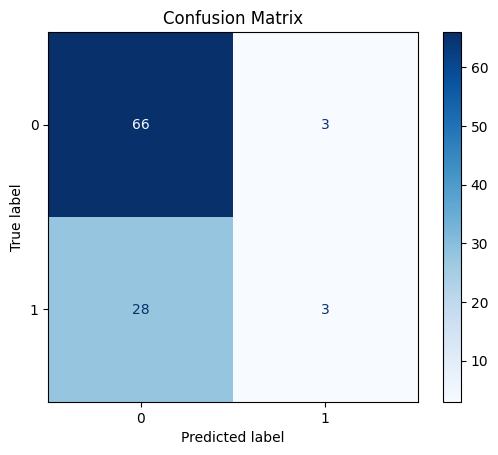

In [130]:
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [131]:
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

True Negatives (TN): 66
False Positives (FP): 3
False Negatives (FN): 28
True Positives (TP): 3
Precision: 0.5
Recall: 0.0967741935483871
F1 Score: 0.16216216216216214


In [132]:
df['Signal'] = 0

df.loc[X_test.index, 'Signal'] = model.predict(X_test)

df['Position'] = 0

holding_position = False

In [133]:

BaroSD = 13.14880598
BaroMean = 54.67908753
BaroCount = 1885

Baro_MINUS_05_SD = BaroMean - ( 0.5 * BaroSD )
Baro_MINUS_1_SD = BaroMean - ( 1 * BaroSD )
Baro_MINUS_15_SD = BaroMean - ( 1.5 * BaroSD )
Baro_MINUS_2_SD = BaroMean - ( 2 * BaroSD )

Baro_PLUS_05_SD = BaroMean + ( 0.5 * BaroSD )
Baro_PLUS_1_SD = BaroMean + ( 1 * BaroSD )
Baro_PLUS_15_SD = BaroMean + ( 1.5 * BaroSD )
Baro_PLUS_2_SD = BaroMean + ( 2 * BaroSD )


print(f"{Baro_MINUS_05_SD:.3f} | {Baro_PLUS_05_SD:.3f}")
print(f"{Baro_MINUS_1_SD:.3f} | {Baro_PLUS_1_SD:.3f}")
print(f"{Baro_MINUS_15_SD:.3f} | {Baro_PLUS_15_SD:.3f}")
print(f"{Baro_MINUS_2_SD:.3f} | {Baro_PLUS_2_SD:.3f}")

48.105 | 61.253
41.530 | 67.828
34.956 | 74.402
28.381 | 80.977


In [134]:
ol = []
cl = []

In [135]:
start_idx = df.index.get_loc(X_test.index[0])

date_list = news["Date"].tolist()

print(date_list)

for i in range(start_idx, len(df)):

    curDate = str(df.index[i].date())

    # print(curDate)
    # print(news['Date'][2])
    # curList = (news['Date'][2] == curDate)
    # print(curList)
    # print(type(curDate))
    # print(type(news['Date'][2]))

    stockList = []

    date_obj = datetime.strptime(curDate, "%Y-%m-%d")
    curDateDDMMYYYY = date_obj.strftime("%d/%m/%Y")

    curData =  news[news['Date'] == curDateDDMMYYYY]

    # print(curDateDDMMYYYY)

    isIn = curDateDDMMYYYY in date_list
    # print(isIn)
    # if (curDate in date_list):
    if (isIn):
        stockList = curData["stockList"].iloc[0]

    # print(stockList)

    if tickerSymbol.replace("^", "")[:-3] not in stockList:
        # print(f"{tickerShort} not in !!")
        # print("NOT IN")
        tickerSymbol = tickerSymbol
    # if df.loc[df.index[i], 'Signal'] == 1 and df.loc[df.index[i], 'Baro-3'] < Baro_MINUS_1_SD and not holding_position:
    # if df.loc[df.index[i], 'Baro-S2'] < Baro_MINUS_05_SD and not holding_position:
    elif df.loc[df.index[i], 'Baro-S2'] < Baro_MINUS_05_SD and not holding_position:
        df.loc[df.index[i], 'Position'] = 1
        holding_position = True
        ol.append(df.index[i])
    # elif df.loc[df.index[i], 'Signal'] == 0 and df.loc[df.index[i], 'Baro-3'] > Baro_PLUS_1_SD and holding_position:
    elif df.loc[df.index[i], 'Baro-S2'] > Baro_PLUS_05_SD and holding_position:
        df.loc[df.index[i], 'Position'] = 0
        holding_position = False
        cl.append(df.index[i])

['01/01/2024', '02/01/2024', '03/01/2024', '04/01/2024', '05/01/2024', '06/01/2024', '07/01/2024', '08/01/2024', '09/01/2024', '10/01/2024', '11/01/2024', '12/01/2024', '13/01/2024', '14/01/2024', '15/01/2024', '16/01/2024', '17/01/2024', '18/01/2024', '19/01/2024', '20/01/2024', '21/01/2024', '22/01/2024', '23/01/2024', '24/01/2024', '25/01/2024', '26/01/2024', '27/01/2024', '28/01/2024', '29/01/2024', '30/01/2024', '31/01/2024', '01/02/2024', '02/02/2024', '03/02/2024', '04/02/2024', '05/02/2024', '06/02/2024', '07/02/2024', '08/02/2024', '09/02/2024', '10/02/2024', '11/02/2024', '12/02/2024', '13/02/2024', '14/02/2024', '15/02/2024', '16/02/2024', '17/02/2024', '18/02/2024', '19/02/2024', '20/02/2024', '21/02/2024', '22/02/2024', '23/02/2024', '24/02/2024', '25/02/2024', '26/02/2024', '27/02/2024', '28/02/2024', '29/02/2024', '01/03/2024', '02/03/2024', '03/03/2024', '04/03/2024', '05/03/2024', '06/03/2024', '07/03/2024', '08/03/2024', '09/03/2024', '10/03/2024', '11/03/2024', '12/0

In [136]:
ol

[Timestamp('2024-01-08 00:00:00+0700', tz='Asia/Bangkok'),
 Timestamp('2024-02-06 00:00:00+0700', tz='Asia/Bangkok'),
 Timestamp('2024-04-03 00:00:00+0700', tz='Asia/Bangkok'),
 Timestamp('2024-05-03 00:00:00+0700', tz='Asia/Bangkok'),
 Timestamp('2024-06-07 00:00:00+0700', tz='Asia/Bangkok')]

In [137]:
cl

[Timestamp('2024-02-02 00:00:00+0700', tz='Asia/Bangkok'),
 Timestamp('2024-02-15 00:00:00+0700', tz='Asia/Bangkok'),
 Timestamp('2024-04-19 00:00:00+0700', tz='Asia/Bangkok'),
 Timestamp('2024-05-24 00:00:00+0700', tz='Asia/Bangkok'),
 Timestamp('2024-06-20 00:00:00+0700', tz='Asia/Bangkok')]

In [138]:
print(len(X_test))

100


In [139]:
df.loc[df['Position'] == 0, 'Position'] = np.nan

df['Position'] = df['Position'].fillna(method='ffill')

df['Position'] = df['Position'].fillna(0).astype(int)

df_test_period = df.loc[X_test.index[0]:]

df_test_period = df_test_period.copy()

df_test_period.loc[:, 'Strategy_Returns'] = df_test_period['Position'].shift(1) * df_test_period['Close'].pct_change()

df_test_period.dropna(subset=['Strategy_Returns'], inplace=True)

returns = df_test_period['Strategy_Returns']

cumulative_returns = (1 + returns).cumprod() - 1

perf_stats = {
    'Annual Return': ep.annual_return(returns),
    'Cumulative Returns': ep.cum_returns_final(returns),
    'Annual Volatility': ep.annual_volatility(returns),
    'Sharpe Ratio': ep.sharpe_ratio(returns),
    'Sortino Ratio': ep.sortino_ratio(returns),
    'Max Drawdown': ep.max_drawdown(returns),
    'Calmar Ratio': ep.calmar_ratio(returns)
}

C:\Users\HP Victus 16\AppData\Local\Temp\ipykernel_27660\2088563721.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Position'] = df['Position'].fillna(method='ffill')


In [140]:
for i,j in perf_stats.items():
    print(f"{i} : {j}")

Annual Return : -0.0165521492951215
Cumulative Returns : -0.0065355971257247125
Annual Volatility : 0.16430123245119382
Sharpe Ratio : -0.020964169977178104
Sortino Ratio : -0.034273717303366404
Max Drawdown : -0.0981276129611126
Calmar Ratio : -0.16867983226781455
